# EEG LDA Notebook

## Necessary Imports

In [ ]:
!python -m pip install mat73
!python -m pip install mne

In [ ]:
from tqdm import tqdm
import mat73
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold,GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,precision_score,recall_score,confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import joblib


: 

## Loading MATLAB Data

In [3]:
#processing MATLAB Function

import mat73
import numpy as np
import mne


chan_names = ['EOGv', 'Fp1', 'Fp2', 'AF3', 'AF4', 'EOGh', 'F7', 'F5', 'F3', 'F1' , 'Fz' , 'F2' , 'F4' , 'F6' , 'F8' , 'FT7' , 'FC5' , 'FC3' ,
              'FC1' , 'FCz' , 'FC2' , 'FC4' , 'FC6' , 'FT8' , 'T7' , 'C5' , 'C3' , 'C1' , 'Cz' , 'C2' , 'C4' , 'C6' , 'T8' , 'TP7' , 'CP5' ,
              'CP3' , 'CP1' , 'CPz' , 'CP2' , 'CP4' , 'CP6' , 'TP8' , 'P9' , 'P7' , 'P5' , 'P3' , 'P1' , 'Pz' , 'P2' , 'P4' , 'P6' , 'P8' ,
            'P10' , 'PO7' , 'PO3' , 'POz' , 'PO4' , 'PO8' , 'O1' , 'Oz' , 'O2' , 'EMGf' , 'lead_gas','lead_brake','dist_to_lead',
              'wheel_X','wheel_Y','gas','brake']



def load_MATLAB_data(dir=None, participant_data=None):
    if dir==None and participant_data==None: raise Exception("Must provide directory or dicitionary")
    # print(dir)
    #load data
    if participant_data == None:
      participant_data = mat73.loadmat(dir)

    eeg_names = chan_names[1:61]
    eeg_names.pop(4)


    #create MNE info object
    sfreq = 200
    n_channels = 59
    # Initialize an info structure
    info = mne.create_info(
            ch_names = eeg_names,
            ch_types = ['eeg']*n_channels,
            sfreq    = sfreq
            )

    info.set_montage('standard_1020')

    #create labels
    Y  = participant_data['mrk']['y']
    Y = np.rollaxis(Y, 1, 0)
    _, ind = np.where(Y>0)
    np.unique(ind)
    labels = ind + 1

    #create event dict
    event_id = dict(car_normal = 1, car_brake = 2,	car_hold = 3,	car_collision = 4,	react_emg = 5)
    eventLength = Y.shape[0]
    ev = np.array([int(participant_data['mrk']['time'][i]/5) for i in range(eventLength)])
    #delete duplicates
    # ev = np.delete(ev, 578, 0)
    # labels = np.delete(labels, 578, 0)

    events = np.column_stack((np.array(ev),
                          np.zeros(eventLength,  dtype = int),
                          np.array(labels)))

    #get time intervals around each y
    # stim_slices = [participant_data['cnt']['x'][int(idx/5)-340:int(idx/5)+240] for idx in participant_data['mrk']['time']]
    stim_slices = [participant_data['cnt']['x'][int(idx/5)-60:int(idx/5)+240] for idx in participant_data['mrk']['time']]


    # stim_slices.pop(578) #remove duplicates

    #reshape data
    npdata = np.array(stim_slices, dtype=object,)
    npdata = np.swapaxes(npdata, 1,2)
    npdata = np.delete(npdata, 0, 1)
    npdata = np.delete(npdata, 4, 1)
    npdata = np.delete(npdata, np.s_[59:], 1)

    # tmin = 0
    #     # Create the :class:`mne.EpochsArray` object
    # epochs = mne.EpochsArray(npdata, info, events, tmin, event_id)

    raw_data = np.swapaxes(np.array(participant_data['cnt']['x']), 0, 1)

    raw_data = np.delete(raw_data, 0, 0)
    raw_data = np.delete(raw_data, 4, 0)
    raw_data = np.delete(raw_data, np.s_[59:], 0)

    raw_eeg = mne.io.RawArray(raw_data,info, verbose=True)


    # epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-1.7, tmax=1.2, preload=True, event_repeated='drop', verbose=True)
    epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-0.3, tmax=1.2, preload=True, event_repeated='drop', verbose=True)



    return raw_eeg, epochs

In [4]:
#processing MATLAB Function

import mat73
import numpy as np
import mne


chan_names = ['EOGv', 'Fp1', 'Fp2', 'AF3', 'AF4', 'EOGh', 'F7', 'F5', 'F3', 'F1' , 'Fz' , 'F2' , 'F4' , 'F6' , 'F8' , 'FT7' , 'FC5' , 'FC3' ,
              'FC1' , 'FCz' , 'FC2' , 'FC4' , 'FC6' , 'FT8' , 'T7' , 'C5' , 'C3' , 'C1' , 'Cz' , 'C2' , 'C4' , 'C6' , 'T8' , 'TP7' , 'CP5' ,
              'CP3' , 'CP1' , 'CPz' , 'CP2' , 'CP4' , 'CP6' , 'TP8' , 'P9' , 'P7' , 'P5' , 'P3' , 'P1' , 'Pz' , 'P2' , 'P4' , 'P6' , 'P8' ,
            'P10' , 'PO7' , 'PO3' , 'POz' , 'PO4' , 'PO8' , 'O1' , 'Oz' , 'O2' , 'EMGf' , 'lead_gas','lead_brake','dist_to_lead',
              'wheel_X','wheel_Y','gas','brake']



def load_MATLAB_data_epoch(dir=None, participant_data=None):
    if dir==None and participant_data==None: raise Exception("Must provide directory or dicitionary")
    # print(dir)
    #load data
    if participant_data == None:
      participant_data = mat73.loadmat(dir)

    eeg_names = chan_names[1:61]
    eeg_names.pop(4)


    #create MNE info object
    sfreq = 200
    n_channels = 59
    # Initialize an info structure
    info = mne.create_info(
            ch_names = eeg_names,
            ch_types = ['eeg']*n_channels,
            sfreq    = sfreq
            )

    info.set_montage('standard_1020')

    #create labels
    Y  = participant_data['mrk']['y']
    Y = np.rollaxis(Y, 1, 0)
    _, ind = np.where(Y>0)
    np.unique(ind)
    labels = ind + 1

    #create event dict
    event_id = dict(car_normal = 1, car_brake = 2,	car_hold = 3,	car_collision = 4,	react_emg = 5)
    eventLength = Y.shape[0]
    ev = np.array([int(participant_data['mrk']['time'][i]/5) for i in range(eventLength)])
    #delete duplicates
    # ev = np.delete(ev, 578, 0)
    # labels = np.delete(labels, 578, 0)

    events = np.column_stack((np.array(ev),
                          np.zeros(eventLength,  dtype = int),
                          np.array(labels)))

    #get time intervals around each y
    # stim_slices = [participant_data['cnt']['x'][int(idx/5)-340:int(idx/5)+240] for idx in participant_data['mrk']['time']]
    stim_slices = [participant_data['cnt']['x'][int(idx/5)-60:int(idx/5)+240] for idx in participant_data['mrk']['time']]


    # stim_slices.pop(578) #remove duplicates

    #reshape data
    npdata = np.array(stim_slices, dtype=object,)
    npdata = np.swapaxes(npdata, 1,2)
    npdata = np.delete(npdata, 0, 1)
    npdata = np.delete(npdata, 4, 1)
    npdata = np.delete(npdata, np.s_[59:], 1)

    # tmin = 0
    #     # Create the :class:`mne.EpochsArray` object
    # epochs = mne.EpochsArray(npdata, info, events, tmin, event_id)

    raw_data = np.swapaxes(np.array(participant_data['cnt']['x']), 0, 1)

    raw_data = np.delete(raw_data, 0, 0)
    raw_data = np.delete(raw_data, 4, 0)
    raw_data = np.delete(raw_data, np.s_[59:], 0)

    raw_eeg = mne.io.RawArray(raw_data,info, verbose=False)


    # epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-1.7, tmax=1.2, preload=True, event_repeated='drop', verbose=True)
    epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-1.7, tmax=1.2, preload=True, event_repeated='drop', verbose=False)



    return raw_eeg, epochs

In [5]:
vpdx_raw, vpdx_epochs = load_MATLAB_data_epoch("VPae.mat")

### Visualize Plots

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


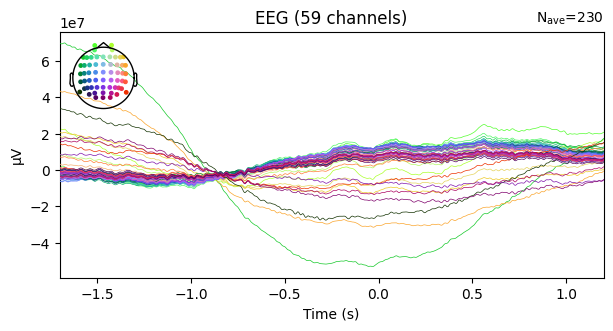

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


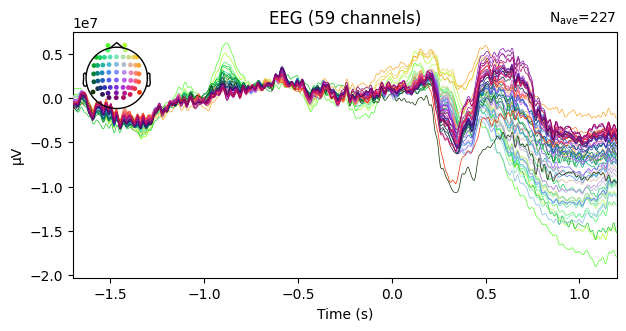

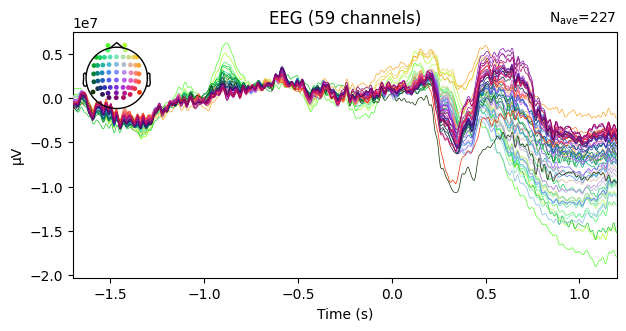

In [6]:
vpdx_epochs['car_normal'].average().plot()
vpdx_epochs['car_brake'].average().plot()

## Develop ML Model

In [7]:
def get_filtered_data(epoch, vpae_dict):
    non_targets = []
    data_pairs = list(zip(vpae_dict['mrk']['time'], vpae_dict['mrk']['time'][1:]))
    data_pairs = [(int(a[0]/5), int(a[1]/5)) for a in data_pairs]
    # npTarget = np.delete(npTarget, npFiltered, 1)
    for pr in data_pairs:
        counter = pr[0] + 600
        while (counter < pr[1]-900):
            non_targets.append(vpae_dict['cnt']['x'][counter:counter+301])
            counter += 301

    # data_pairs = [(vpae_dict['mrk']['time'][i], vpae_dict['mrk']['time'][i+1]) for i in range(len(vpae_dict['mrk']['time'])-1)]
    # for vpae_dict in mat_dicts:
    # npFiltered = np.where(np.std(epoch['car_normal'].average().get_data(), axis=1) > 2)
    # print(npFiltered)

    # npNonTarget = np.array(non_targets)
    # npNonTarget = np.swapaxes(npNonTarget, 1,2)
    # npNonTarget = np.delete(npNonTarget, 0, 1)
    # npNonTarget = np.delete(npNonTarget, 4, 1)
    # npNonTarget = np.delete(npNonTarget, np.s_[59:], 1)

    npNonTarget = np.array([x[:,-301:] for x in epoch['car_brake'].get_data()])
    # print(npNonTarget.shape)

    return npNonTarget#, npFiltered

In [8]:
def get_target_based_on_time(vpae_dict, length, npFiltered, epoch):

    indices = list(np.where(vpae_dict['mrk']['y'][1] == 1.0)[0])
    times = [vpae_dict['mrk']['time'][x] for x in indices]
    targets = np.array([vpae_dict['cnt']['x'][int(idx/5)+length-1:int(idx/5)+length+300] for idx in times])
        # targets = [vpae_dict['cnt']['x'][int(idx/5)+len:int(idx/5)+len+1] for idx in times]


    npTarget = np.array(targets)
    npTarget = np.swapaxes(npTarget, 1,2)
    npTarget = np.delete(npTarget, 0, 1)
    npTarget = np.delete(npTarget, 4, 1)
    npTarget = np.delete(npTarget, np.s_[59:], 1)
    # npTarget = np.delete(npTarget,npFiltered, 1)

    # npNonTarget = npNonTarget - np.mean(npNonTarget)
    # npNonTarget = npNonTarget / np.std(npNonTarget)
    # npTarget = npTarget - np.mean(npTarget)
    # npTarget = npTarget / np.std(npTarget)

    npTarget = np.array([x[:,length+341-1:length+341+300] for x in epoch['car_brake'].get_data()])
    # print("NpTarget = ", npTarget.shape)
    return npTarget

In [9]:
def create_dataset(npNonTarget, npTarget):
    TR = npTarget 
    TR = np.swapaxes(TR, 1, 2)
    TR = np.swapaxes(TR, 0, 1)
    TR = np.mean(TR, axis=2)
    TR = np.swapaxes(TR, 0, 1)

    FL = npNonTarget 
    FL = np.swapaxes(FL, 1, 2)
    FL = np.swapaxes(FL, 0, 1)
    FL = np.mean(FL, axis=2)
    FL = np.swapaxes(FL, 0, 1)


    # TR = sc.fit_transform(TR)
    # FL = sc.fit_transform(FL)

    TrueLabels = [1 for sample in range(TR.shape[0])]
    FalseLabels = [0 for sample in range(FL.shape[0])]

    X = np.concatenate((TR, FL))
    y = np.concatenate((TrueLabels, FalseLabels))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # print(X_train.shape)

    return X_train, X_test, y_train, y_test
    

In [10]:
def create_PCA_LDA_OVER(X_train, X_test, y_train, y_test):
    # pca = PCA(n_components=10)
    # X_train = pca.fit_transform(X_train)
    # X_test = pca.transform(X_test)
    
    # # sc = StandardScaler()
    # # X_train = sc.fit_transform(X_train)
    # # X_test = sc.transform(X_test)

    # oversample = SMOTE()
    # Xs_train, Xs_test, ys_train, ys_test = X_train, X_test, y_train, y_test
    # Xs_train, ys_train = oversample.fit_resample(Xs_train, ys_train)

    # pca_os = PCA(n_components=10)
    # Xs_train = pca_os.fit_transform(Xs_train)
    # Xs_test = pca_os.transform(Xs_test)

    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    # grid = dict()
    # grid['solver'] = ['eigen','lsqr']
    # grid['shrinkage'] = ['auto',0.2,1,0.3,0.5]
    # search = GridSearchCV(LDA(), grid, scoring='precision', cv=cv, n_jobs=8)
    # results = search.fit(Xs_train, ys_train)


    # LDA_final=LDA(shrinkage='auto', solver='eigen')
    # LDA_final.fit(Xs_train,ys_train)

    # print(X_test.shape)


    # # save the model to disk
    # filename = 'PCA_LDA_OVER_model.sav'
    # joblib.dump(LDA_final, filename)

    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    # pipe = Pipeline([('ovr', SMOTE()), ('pca', PCA()), ('cv', RepeatedStratifiedKFold()), ('lda', LDA())])
    pipe = Pipeline([('pca', PCA()), ('lda', LDA())])
    pipe.fit(X_train, y_train)

    ys_pred = pipe.predict(X_test)

    # ConfusionMatrixDisplay.from_predictions(y_test, ys_pred)
    acc = accuracy_score(y_test, ys_pred)
    ys_pred_proba = pipe.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, ys_pred_proba)
    f1 = f1_score(y_test, ys_pred)
    return acc, auc_score, f1


In [11]:
def train_one_trial(dir, length):
    
    participant_data = mat73.loadmat(dir)
    raw, epochs = load_MATLAB_data_epoch(participant_data=participant_data)
    npNonTarget = get_filtered_data(epochs, participant_data)
    npTarget = get_target_based_on_time(participant_data, length, _, epochs)

    X_train, X_test, y_train, y_test = create_dataset(npNonTarget, npTarget)
    
    # print(X_train.shape)
    try:
        acc, auc_score, f1 = create_PCA_LDA_OVER(X_train, X_test, y_train, y_test)
        return acc, auc_score, f1
    except:
        print("Problem")





Creating RawArray with float64 data, n_channels=59, n_times=1619949
    Range : 0 ... 1619948 =      0.000 ...  8099.740 secs
Ready.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1669 matching events found
Setting baseline interval to [-1.7, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1669 events and 581 original time points ...
0 bad epochs dropped
(206, 59, 301)
NpTarget =  (206, 59, 301)
(329, 301)
(329, 301)
Accuracy:  0.6265060240963856
AUC Score:  0.6381118881118881
F1 Score:  0.651685393258427


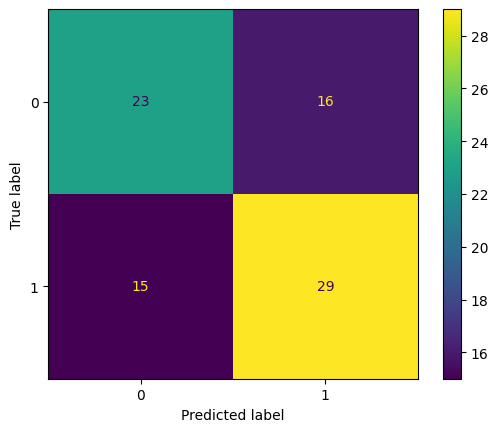

In [129]:
acc, auc_score, f1 = train_one_trial(dir="VPdx.mat", length=-340)

print("Accuracy: ", acc)
print("AUC Score: ", auc_score)
print("F1 Score: ", f1)

In [12]:
def train_participant(dir, st):
    AUC_scores = []
    accuracies = []
    F1_scores = []
    for length in tqdm(range(-340, -60, st)):
        print("Time ", 1500+5*length)
        acc, auc_score, f1 = train_one_trial(dir, length)
        AUC_scores.append(auc_score)
        accuracies.append(acc)
        F1_scores.append(f1)

    return AUC_scores, accuracies, F1_scores

### Test Run

In [13]:
AUC_scores, accuracies, F1_scores = train_participant("VPsaj.mat", 20)

  0%|          | 0/14 [00:00<?, ?it/s]

Time  -200


  0%|          | 0/14 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [14]:
import os
from tqdm import tqdm

mat_files = []


files_dir = ".\\"
AUC_Matrix = []
Acc_Matrix = []
F1_Matrix = []

for filename in tqdm(os.listdir(files_dir)):
    f = os.path.join(files_dir, filename)
    if os.path.isfile(f) and f[-3:] == "mat":
        mat_files.append(f)

for file in tqdm(mat_files):
    try:
        print(file)
        AUC, acc, F1 = train_participant(file, 4)
    except:
        print("An exception occurred")
    AUC_Matrix.append(AUC)
    Acc_Matrix.append(acc)
    F1_Matrix.append(F1)


  0%|          | 0/18 [00:00<?, ?it/s]

.\VPae.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


  6%|▌         | 1/18 [07:15<2:03:26, 435.68s/it]

.\VPbad.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 11%|█         | 2/18 [13:48<1:49:29, 410.62s/it]

.\VPbax.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 17%|█▋        | 3/18 [19:56<1:37:45, 391.06s/it]

.\VPbba.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 22%|██▏       | 4/18 [26:32<1:31:42, 393.05s/it]

.\VPdx.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 28%|██▊       | 5/18 [33:58<1:29:16, 412.07s/it]

.\VPgaa.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 33%|███▎      | 6/18 [41:13<1:23:59, 419.97s/it]

.\VPgab.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 39%|███▉      | 7/18 [47:53<1:15:47, 413.40s/it]

.\VPgac.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 44%|████▍     | 8/18 [54:00<1:06:26, 398.62s/it]

.\VPgae.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 50%|█████     | 9/18 [59:57<57:49, 385.50s/it]  

.\VPgag.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 56%|█████▌    | 10/18 [1:06:11<50:56, 382.11s/it]

.\VPgah.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 61%|██████    | 11/18 [1:12:07<43:38, 374.11s/it]

.\VPgal.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 67%|██████▋   | 12/18 [1:18:04<36:53, 368.86s/it]

.\VPgam.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 72%|███████▏  | 13/18 [1:24:06<30:33, 366.72s/it]

.\VPih.mat


Time  -200


 78%|███████▊  | 14/18 [1:24:09<17:07, 256.92s/it]

An exception occurred
.\VPii.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 83%|████████▎ | 15/18 [1:30:16<14:30, 290.23s/it]

.\VPja.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 89%|████████▉ | 16/18 [1:36:15<10:21, 310.64s/it]

.\VPsaj.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


 94%|█████████▍| 17/18 [1:42:24<05:28, 328.31s/it]

.\VPsal.mat


Time  -200


Time  -180


Time  -160


Time  -140


Time  -120


Time  -100


Time  -80


Time  -60


Time  -40


Time  -20


Time  0


Time  20


Time  40


Time  60


Time  80


Time  100


Time  120


Time  140


Time  160


Time  180


Time  200


Time  220


Time  240


Time  260


Time  280


Time  300


Time  320


Time  340


Time  360


Time  380


Time  400


Time  420


Time  440


Time  460


Time  480


Time  500


Time  520


Time  540


Time  560


Time  580


Time  600


Time  620


Time  640


Time  660


Time  680


Time  700


Time  720


Time  740


Time  760


Time  780


Time  800


Time  820


Time  840


Time  860


Time  880


Time  900


Time  920


Time  940


Time  960


Time  980


Time  1000


Time  1020


Time  1040


Time  1060


Time  1080


Time  1100


Time  1120


Time  1140


Time  1160


Time  1180


100%|██████████| 18/18 [1:48:30<00:00, 361.72s/it]


Text(0, 0.5, 'Accuracy')

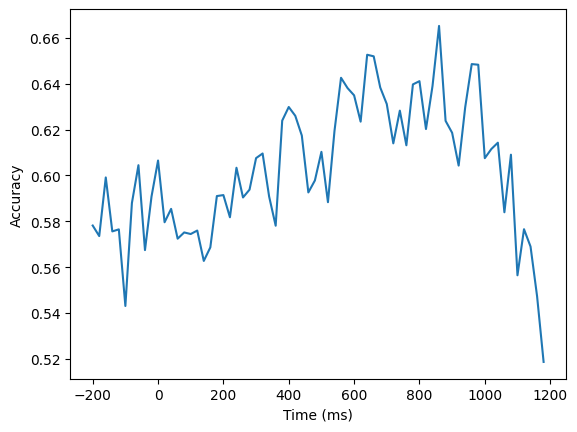

In [18]:

mns = np.mean(AUC_Matrix, axis=0)
data = [(-200+5*i, mns[i]) for i in range(len(mns))]

plt.plot(np.arange(-200, 1200, 20), mns) 
plt.xlabel('Time (ms)')
plt.ylabel('Accuracy')

## Real Time Model

In [27]:
class livePredictor():
    def __init__(self, model, interval_time, num_channels):
        self.INTERVAL_TIME = interval_time
        self.num_channels = num_channels
        self.data = np.zeros(shape=(self.INTERVAL_TIME, self.num_channels))
        self.model = model
        self.counter = 0

    def readData(self, sample):
        if self.counter == self.INTERVAL_TIME:
            self.data = np.concatenate((sample, self.data[1:]))
        else:
            self.data[self.counter] = sample
            self.counter += 1
    
    def predict(self):
        return self.model.predict(self.data)
    
    def trainModel(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        return self.model.fit(X_train, y_train).score(X_test, y_test)

        


In [29]:
lP = livePredictor("PCA_LDA_OVER_model.sav", 301, 59)

In [25]:
lP.readData([])